# 📔 About this notebook

PetFinder.my - Pawpularity Contest



## 📝 Memo

- transformer の output と feature を SVR で学習する。
    - NN の head と SVR でアンサンブルする。 [Link](https://www.kaggle.com/cdeotte/rapids-svr-boost-17-8/notebook)
- 推論画像も crop する

# 📚 Library

In [1]:
# General libraries
import collections
import gc
import glob
import json
import math
import os
import random
import re
import statistics
import sys
import time
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import wandb
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [2]:
# Competition specific libraries
import albumentations as A
import cv2
import timm
from albumentations.pytorch import ToTensorV2

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# netrc = "/content/drive/MyDrive/.netrc" if 'google.colab' in sys.modules else "../input/wandbtoken/.netrc"
# !cp -f {netrc} ~/
!wandb login
wandb_tags = []

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [6]:
DATA_DIR = "../input/petfinder-pawpularity-score/"
OUTPUT_DIR = "./"
MODEL_DIR = "./models/"

!rm -rf {MODEL_DIR}

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [7]:
train = pd.read_csv(DATA_DIR + "train.csv")
test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submission.csv")

TRAIN_IMAGE_PATH = DATA_DIR + "train/"
TEST_IMAGE_PATH = DATA_DIR + "test/"

# 🛠 Config

In [8]:
# seed = random.randrange(10000)
seed = 440
print(seed)

440


In [9]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "petfinder2"
    print_freq = 100

    train = True
    validate = False
    inference = False

    debug = False
    num_debug_data = 1000

    amp = True
    multi_gpu = True

Model examples

- resnext50_32x4d
- vit_base_patch16_384
- tf_efficientnetv2_m_in21k
- swin_large_patch4_window12_384_in22k

In [10]:
config_defaults = {
    "seed": seed,
    "n_class": 1,
    "n_fold": 10,
    "epochs": 20,
    "es_patience": 0,
    "batch_size": 64,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1000,
    "criterion": "BCEWithLogitsLoss",
    "optimizer": "SAM",
    "scheduler": "CosineAnnealingWarmRestarts",
    "lr": 1e-4,
    "min_lr": 1e-6,
    "weight_decay": 1e-7,
    "momentum": 0.9,
    "model_name": "swin_large_patch4_window12_384_in22k",
    "size": 384,
}

In [11]:
if Config.debug:
    config_defaults["n_fold"] = 3
    config_defaults["epochs"] = 1
    Config.print_freq = 10

In [12]:
if Config.train:
    wandb_job_type = "training"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

else:
    wandb_job_type = ""

In [13]:
if Config.debug:
    wandb_tags.append("debug")

# if Config.amp:
#     wandb_tags.append("amp")

In [14]:
# wandb_tags.append("feats")
wandb_tags.append("bins kfold")
wandb_tags.append("basic aug")
# wandb_tags.append("heavy aug")
# wandb_tags.append("mixup")
# wandb_tags.append("cutmix")
# wandb_tags.append("freeze norm")
# wandb_tags.append("crop image")

In [15]:
if Config.debug:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        tags=wandb_tags,
        mode="disabled",
    )
else:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        job_type=wandb_job_type,
        tags=wandb_tags,
        save_code=True,
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [16]:
config = wandb.config

# EDA 1

In [17]:
for df in [train, test, sub]:
    print(f"=" * 120)
    df.info()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             8 non-null      object
 1   Subject Focus  8 non-null      int64 
 2   Eyes           8 non-null      int64 
 3   Face           8 non-null      int64 
 4   Near           8 non-null      int64 
 5   Action         8 non-null      int64 
 6   Accessory      8 non-null      int64 
 7   Group          8 non-null      int64 
 8   Collage        8 non-null      int64 
 9   Human          8 non-null      int64 
 10  Occlusion      8 non-null      int64 
 11  Info           8 non-null      int64 
 12  Blur           8 non-null      int64 
dtypes: int64(12), object(1)
memory usage: 960.0+ bytes


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           8 non-null      object 
 1   Pawpularity  8 non-null      float64
dtypes: float64(1), object(1)
memory usage: 256.0+ bytes


,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,67.75
1,43a2262d7738e3d420d453815151079e,59.15
2,4e429cead1848a298432a0acad014c9d,20.02
3,80bc3ccafcc51b66303c2c263aa38486,94.53
4,8f49844c382931444e68dffbe20228f4,89.82


<AxesSubplot:xlabel='Pawpularity'>

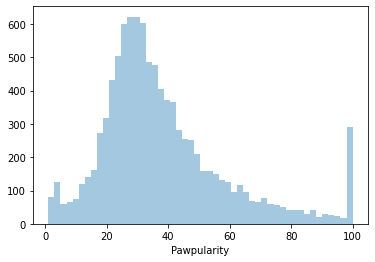

In [18]:
sns.distplot(train["Pawpularity"], kde=False)

# Preprocess

# EDA 2

# 👑 Load Artifacts

In [19]:
if Config.debug:
    train = train.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
    if len(sub) > Config.num_debug_data:
        test = test.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
        sub = sub.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)

# Utils

In [20]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)

# Make Fold

In [21]:
num_bins = int(np.floor(1 + np.log2(len(train))))
train.loc[:, "bins"] = pd.cut(train["Pawpularity"], bins=num_bins, labels=False)

In [22]:
Fold = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
    train.loc[val_index, "fold"] = int(n)
train["fold"] = train["fold"].astype(np.int8)
print(train.groupby(["fold", "bins"]).size())

fold  bins
0     0        33
      1        42
      2       111
      3       203
      4       188
             ... 
9     9        28
      10       20
      11       14
      12       11
      13       36
Length: 140, dtype: int64


# Dataset

In [23]:
if "crop image" in wandb_tags:
    TRAIN_IMAGE_PATH = DATA_DIR + "crop/"

In [24]:
class BaseDataset(Dataset):
    def __init__(self, df, transform=None, label=True):
        self.df = df
        self.file_names = df["Id"].values
        self.features = df.drop(["Id", "Pawpularity", "fold", "bins"], axis=1).values
        self.transform = transform

        self.use_label = label
        if self.use_label:
            self.path = TRAIN_IMAGE_PATH
            self.labels = df["Pawpularity"].values / 100.0
        else:
            self.path = TEST_IMAGE_PATH

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{self.path}/{file_name}.jpg"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        feature = torch.tensor(self.features[idx])
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        if self.use_label:
            label = torch.tensor(self.labels[idx])
            return image, feature, label
        return image, feature

In [25]:
if Config.debug:
    train_ds = BaseDataset(train)
    image, feature, label = train_ds[0]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transform

In [26]:
def get_transforms(*, data):
    if data == "train":
        if "basic aug" in wandb_tags:
            return A.Compose(
                [
                    # A.Resize(config.size, config.size),
                    A.RandomResizedCrop(config.size, config.size),
                    A.Transpose(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(p=0.5),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                    ToTensorV2(),
                ]
            )

        if "heavy aug" in wandb_tags:
            return A.Compose(
                [
                    # A.Resize(config.size, config.size),
                    A.RandomResizedCrop(config.size, config.size),
                    A.Transpose(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.ShiftScaleRotate(p=0.5),
                    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                    # A.CoarseDropout(p=0.5),
                    # A.Cutout(p=0.5),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                    ToTensorV2(),
                ]
            )

    return A.Compose(
        [
            A.Resize(config.size, config.size),
            # A.CenterCrop(config.size, config.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ]
    )

In [27]:
if Config.debug:
    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    image, feature, label = train_ds[0]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

## CutMix

In [28]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(x, feats, y, alpha=1.0, use_cuda=True):
    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    mixed_x = x.clone()
    mixed_x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    mixed_feats = lam * feats + (1 - lam) * feats[index]
    y_a, y_b = y, y[index]

    return mixed_x, mixed_feats, y_a, y_b, lam

In [29]:
if Config.debug and config.model_name != "":
    train_ds = BaseDataset(train, transform=get_transforms(data="valid"))
    train_loader = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        image, feature, label_a, label_b, lam = cutmix(image, feature, label, alpha=0.5, use_cuda=False)

        plt.imshow(image[0].permute(1, 2, 0))
        plt.title(f"label: {label_a[0]} and {label_b[0]}")
        plt.show()

        print(f"feature: {feature[0]}, lam: {lam}")
        break

## MixUp

In [30]:
# https://github.com/yuhao318/mwh/blob/main/utils.py
def mixup(x, feats, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_feats = lam * feats + (1 - lam) * feats[index]
    y_a, y_b = y, y[index]

    # return mixed_image, mixed_label, lam
    return mixed_x, mixed_feats, y_a, y_b, lam

In [31]:
if Config.debug and config.model_name != "":
    train_ds = BaseDataset(train, transform=get_transforms(data="valid"))
    train_loader = DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        image, feature, label_a, label_b, lam = mixup(image, feature, label, alpha=0.5, use_cuda=False)

        plt.imshow(image[0].permute(1, 2, 0))
        plt.title(f"label: {label_a[0]} and {label_b[0]}")
        plt.show()

        print(f"feature: {feature[0]}, lam: {lam}")
        break

# 🚗 Model

In [32]:
class BaseModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "resnext50_32x4d" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, 128)

        elif "efficientnet" in model_name:
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, 128)

        elif any(key in model_name for key in ["vit", "swin"]):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, 128)

        self.dropout = nn.Dropout(0.1)
        self.head1 = nn.Linear(140, 64)
        self.head2 = nn.Linear(64, config.n_class)

    @amp.autocast(enabled=Config.amp)
    def forward(self, x, feats):
        x = self.model(x)
        x = self.dropout(x)
        x = torch.cat([x, feats], dim=1)
        x = self.head1(x)
        x = self.head2(x)
        return x

In [33]:
def train_mode(model):
    model.train()

    # Freeze layer normalization
    if any(key in config.model_name for key in ["vit", "swin"]):
        for m in model.modules():
            for child in m.children():
                if isinstance(child, nn.LayerNorm):
                    for param in child.parameters():
                        param.requires_grad = False

In [34]:
if Config.debug and config.model_name != "":
    model = BaseModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, feature, label in train_loader:
        output = model(image, feature)
        print(output)
        break

In [35]:
if Config.debug and config.model_name != "":
    model = BaseModel(config.model_name)
    model.apply(train_mode)

    for n, (name, tensor) in enumerate(list(model.named_parameters())):
        print(f"{n:>4}: {tensor.requires_grad}, {name}")

# Optimizer

In [36]:
# https://github.com/davda54/sam/blob/main/sam.py
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None:
                    continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][
            0
        ].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
            torch.stack(
                [
                    ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                    for group in self.param_groups
                    for p in group["params"]
                    if p.grad is not None
                ]
            ),
            p=2,
        )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

# Loss

In [37]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

# Scoring

In [38]:
def get_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [39]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["Pawpularity"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    if fold == config.n_fold:
        wandb.log({"Score": score})
    else:
        wandb.log({f"Score_fold{fold}": score})

# Helper functions

In [40]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

## Early stopping

In [41]:
# https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path="checkpoint.pt", trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_preds = None

    def __call__(self, val_loss, score, model, preds):

        if self.best_score is None:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
        elif val_loss >= self.val_loss_min + self.delta:
            if self.patience <= 0:
                return
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_preds = preds
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Grad norm

In [42]:
def compute_grad_norm(parameters, norm_type=2.0):
    """Refer to torch.nn.utils.clip_grad_norm_"""
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type
    total_norm = total_norm ** (1.0 / norm_type)
    return total_norm

## Training

In [43]:
def train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device):
    losses = AverageMeter()

    # switch to train mode
    if "freeze norm" in wandb_tags:
        model.apply(train_mode)
    else:
        model.train()
    start = time.time()
    optimizer.zero_grad()

    for step, (images, features, labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        if epoch < 2 or epoch >= config.epochs - 2:
            mix_decision = 1.0
        else:
            mix_decision = np.random.rand()

        if epoch >= config.epochs - 5:
            mix_decision *= 2

        if "mixup" in wandb_tags and mix_decision < 0.5:
            images, features, label_a, label_b, lam = mixup(images, features, labels, alpha=0.5)

        with amp.autocast(enabled=Config.amp):
            # y_preds = model(images, features)
            y_preds = model(images, features).squeeze(1)

            if "mixup" in wandb_tags and mix_decision < 0.5:
                loss = criterion(y_preds, label_a) * lam + criterion(y_preds, label_b) * (1.0 - lam)
            else:
                loss = criterion(y_preds, labels)

            losses.update(loss.item(), batch_size)
            loss = loss / config.gradient_accumulation_steps

            if config.optimizer == "SAM":

                def closure():
                    # y_preds = model(images, features)
                    y_preds = model(images, features).squeeze(1)

                    if "mixup" in wandb_tags and mix_decision < 0.5:
                        loss = criterion(y_preds, label_a) * lam + criterion(y_preds, label_b) * (1.0 - lam)
                    else:
                        loss = criterion(y_preds, labels)

                    loss.backward()
                    return loss

        scaler.scale(loss).backward()

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

            if config.optimizer == "SAM":
                scaler.step(optimizer, closure)
            else:
                scaler.step(optimizer)

            scaler.update()

            optimizer.zero_grad()
            scheduler.step()
        else:
            grad_norm = compute_grad_norm(model.parameters())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"Grad: {grad_norm:.4f} "
                f"LR: {scheduler.get_lr()[0]:.2e}  "
            )

    return losses.avg

## Validation

In [44]:
def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, features, labels) in enumerate(valid_loader):
        images = images.to(device)
        features = features.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            # y_preds = model(images, features)
            y_preds = model(images, features).squeeze(1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # preds.append(y_preds.softmax(1).to("cpu").numpy())
        preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )

    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Postprocess

# 🏃‍♂️ Train loop

In [45]:
def train_loop(df, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_ = BaseDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_ = DataLoader(
        train_dataset_,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "SAM":
            base_optimizer = SGD
            optimizer = SAM(
                model.parameters(),
                base_optimizer,
                lr=config.lr,
                momentum=config.momentum,
                weight_decay=config.weight_decay,
            )
        elif config.optimizer == "ASAM":
            base_optimizer = SGD
            optimizer = SAM(
                model.parameters(),
                base_optimizer,
                lr=config.lr,
                momentum=config.momentum,
                weight_decay=config.weight_decay,
                rho=2.0,
                adaptive=True,
            )
        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer, train_dataset):
        num_data = len(train_dataset)
        num_steps = num_data // (config.batch_size * config.gradient_accumulation_steps) * config.epochs

        if config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=num_steps, T_mult=1, eta_min=config.min_lr, last_epoch=-1
            )
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=num_steps, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=num_steps,
                max_lr=config.lr,
                min_lr=config.min_lr,
                warmup_steps=(num_steps // 10),
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(config.model_name)
    if Config.multi_gpu:
        model = nn.DataParallel(model)
    model.to(device)

    optimizer = get_optimizer(model)
    scaler = amp.GradScaler(enabled=Config.amp)
    scheduler = get_scheduler(optimizer, train_dataset)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()
        return criterion

    criterion = get_criterion()

    # ====================================================
    # Early stopping
    # ====================================================
    es = EarlyStopping(
        patience=config.es_patience,
        verbose=True,
        path=MODEL_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth",
    )

    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf
    best_preds = None

    for epoch in range(config.epochs):
        start_time = time.time()

        # train
        if epoch < 2 or epoch >= config.epochs - 2:
            avg_loss = train_fn(train_loader_, model, criterion, optimizer, scheduler, scaler, epoch, device)
        else:
            avg_loss = train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["Pawpularity"].values

        if config.criterion == "BCEWithLogitsLoss":
            preds = 1 / (1 + np.exp(-preds))

        preds *= 100.0

        # scoring
        # score = get_score(valid_labels, preds.argmax(1))
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log(
            {
                "epoch": epoch + 1,
                f"loss/train_fold{fold}": avg_loss,
                f"loss/valid_fold{fold}": avg_val_loss,
                f"score/fold{fold}": score,
            }
        )

        es(avg_val_loss, score, model, preds)

        if es.early_stop:
            print("Early stopping")
            break

    # valid_folds[[str(c) for c in range(config.n_class)]] = es.best_preds
    # valid_folds["preds"] = es.best_preds.argmax(1)
    valid_folds["preds"] = es.best_preds

    return valid_folds, es.best_score, es.val_loss_min

# Main function

In [46]:
def main():
    # ====================================================
    # Training
    # ====================================================
    if Config.train:
        oof_df = pd.DataFrame()
        oof_result = []
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df, score, loss = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            oof_result.append([fold, score, loss])

            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)

        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)

        loss = statistics.mean([d[2] for d in oof_result])
        wandb.log({"loss": loss})

        table = wandb.Table(data=oof_result, columns=["fold", "score", "loss"])
        run.log({"Fold Result": table})

        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(config.model_name, type="model")
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)

# 🚀 Run

In [ ]:
main()

========== fold: 0 training ==========


Epoch: [1][0/139] Elapsed 0m 27s (remain 62m 29s) Loss: 0.6930 Grad: 0.6422 LR: 1.00e-04  
Epoch: [1][100/139] Elapsed 2m 40s (remain 1m 0s) Loss: 0.6862 Grad: 0.4616 LR: 9.97e-05  
Epoch: [1][138/139] Elapsed 3m 31s (remain 0m 0s) Loss: 0.6838 Grad: 0.3681 LR: 9.94e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 37s) Loss: 0.6787 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6761 


Epoch 1 - avg_train_loss: 0.6838  avg_val_loss: 0.6761  time: 222s
Epoch 1 - Score: 21.84441268150189


Validation loss decreased (inf --> 0.676132).  Saving model ...
Epoch: [2][0/139] Elapsed 0m 3s (remain 8m 17s) Loss: 0.6710 Grad: 0.4216 LR: 9.94e-05  
Epoch: [2][100/139] Elapsed 2m 18s (remain 0m 52s) Loss: 0.6715 Grad: 0.3426 LR: 9.82e-05  
Epoch: [2][138/139] Elapsed 3m 9s (remain 0m 0s) Loss: 0.6704 Grad: 0.2829 LR: 9.76e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6726 
EVAL: [15/16] Elapsed 0m 9s (remain 0m 0s) Loss: 0.6680 


Epoch 2 - avg_train_loss: 0.6704  avg_val_loss: 0.6680  time: 199s
Epoch 2 - Score: 20.91139038877488


Validation loss decreased (0.676132 --> 0.668036).  Saving model ...
Epoch: [3][0/139] Elapsed 0m 3s (remain 8m 58s) Loss: 0.6590 Grad: 0.4124 LR: 9.76e-05  
Epoch: [3][100/139] Elapsed 2m 18s (remain 0m 52s) Loss: 0.6680 Grad: 0.5038 LR: 9.55e-05  
Epoch: [3][138/139] Elapsed 3m 9s (remain 0m 0s) Loss: 0.6677 Grad: 0.3078 LR: 9.46e-05  
EVAL: [0/16] Elapsed 0m 2s (remain 0m 41s) Loss: 0.6706 


In [ ]:
wandb.finish()